# Kaggle Competition: Don't Overfit! II

In [ ]:
# Import visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [ ]:
# Set the path
datapath = Path(r"path")
os.chdir(datapath)

In [ ]:
# Loading data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submit_data = pd.read_csv("sample_submission.csv")

In [ ]:
# Inspect data
train_data.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [ ]:
# Inspecting data structure
print(train_data.any().isna().value_counts())
print(test_data.any().isna().value_counts())
print(train_data.any().isnull().value_counts())
print(test_data.any().isnull().value_counts())

False    302
dtype: int64
False    301
dtype: int64
False    302
dtype: int64
False    301
dtype: int64


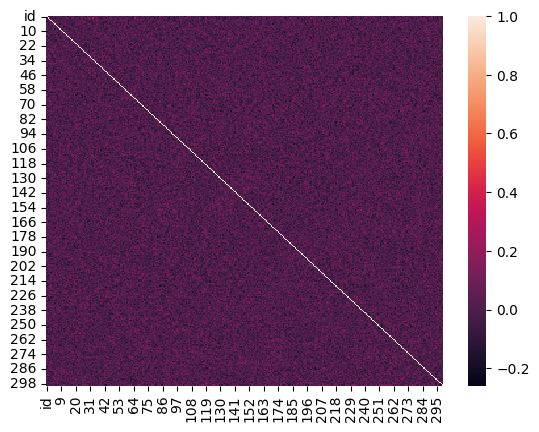

In [ ]:
# Check for correlation
correlation = train_data.corr(method='pearson')
sns.heatmap(correlation)
plt.show()

We can see in the printout below the highest correlation is 0.3375 which is still very low for a correlation coefficient and doesn't need further attention for the preprocessing of the dataset.

In [ ]:
# Getting 16 "highest" correlations
train_data.corr()["target"].sort_values(ascending=False).iloc[1:16]

33     0.373608
65     0.293846
24     0.173096
183    0.164146
199    0.159442
201    0.142238
30     0.132705
289    0.127213
114    0.124792
164    0.124151
101    0.118379
272    0.113909
226    0.113660
17     0.110998
105    0.110589
Name: target, dtype: float64

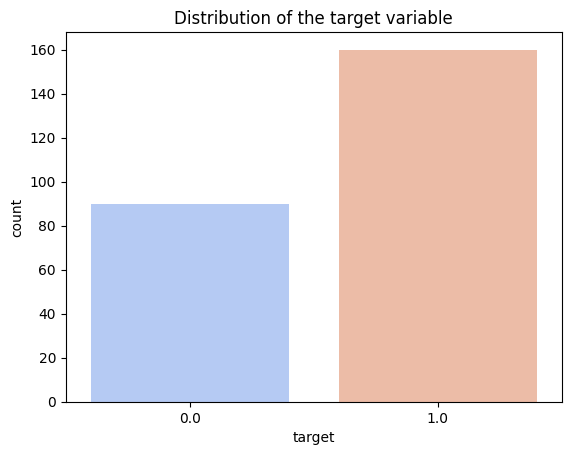

In [ ]:
# Check distribution of target variable
sns.countplot(data= train_data, x= 'target', palette='coolwarm')
plt.title("Distribution of the target variable")
plt.show()


In [ ]:
# Import machine learning and preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Declaring a global seed variable for easy changing
SEED = 147

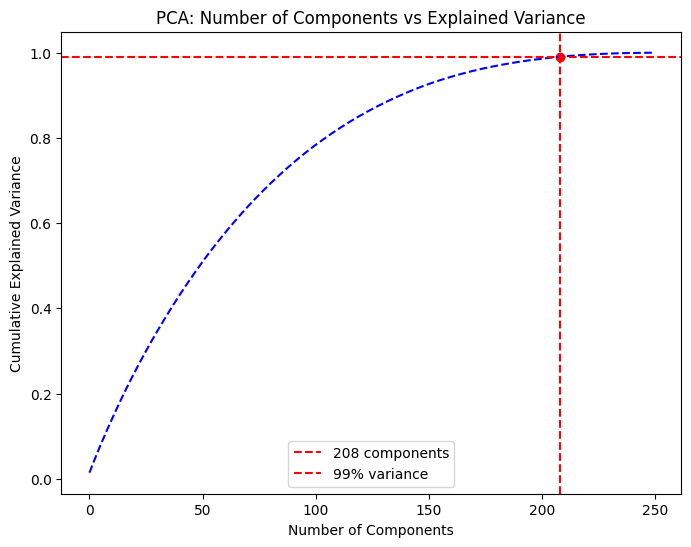

Number of components needed to explain 99% variance: 208


In [5]:
# Prepare features and labels
X = train_data.drop(columns=["id", "target"])
Y = train_data["target"]

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_data_scaled = scaler.transform(test_data.drop(columns="id"))

# Apply PCA
pca = PCA(svd_solver="full")
pca.fit(X_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain 90% variance
components_needed = np.argmax(cumulative_variance >= 0.99) + 1  # Add 1 because indices start from 0

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, linestyle='--', color='b')

# Add vertical line for the number of components
plt.axvline(x=components_needed, color='red', linestyle='--', label=f'{components_needed} components')

# Add horizontal line at 80% explained variance
plt.axhline(y=0.99, color='red', linestyle='--', label='99% variance')

# Mark the intersection point
plt.scatter(components_needed, 0.99, color='red')

# Add labels and title
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Number of Components vs Explained Variance")
plt.legend()

# Show plot
plt.show()

# Print out the number of components needed
print(f"Number of components needed to explain 99% variance: {components_needed}")

In [ ]:
# Apply PCA
pca = PCA(n_components= components_needed, svd_solver="full")
X_pca = pca.fit_transform(X_scaled)
test_data_pca = pca.transform(test_data_scaled)
# Splitting into train and test data for scaled & pca applied and scaled only data
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y, test_size= 0.15, random_state=SEED)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, Y, test_size = 0.15, random_state= SEED)

# Oversampling method for data imbalance in the dataset
smote = SMOTE(random_state = SEED)
x_train_pca, y_train_pca = smote.fit_resample(x_train_pca, y_train_pca)
x_train_scaled, y_train_scaled = smote.fit_resample(x_train_scaled, y_train_scaled)




In [8]:
# Dataframe for the following results for comparison
models = ['Logreg simple', 'Logreg Grid', 'RF simple', 'RF Grid', 'XGB simple', 'XGB grid', 'MLP simple', 'MLP Grid']
results = pd.DataFrame(columns=["Models", "Scaled only", "Scaled with PCA", "Actual score scaled", "Actual score PCA"])
results["Models"] = models


In [9]:
# Logistic regression simple code
log = LogisticRegression(random_state= SEED)

# Section for the pca model 
log.fit(x_train_pca, y_train_pca)
print(log.score(x_train_pca, y_train_pca))
test_pred = log.predict(x_test_pca)

print(accuracy_score(y_test_pca, test_pred))
results["Scaled with PCA"].loc[0] = accuracy_score(y_test_pca, test_pred)

submit_pred = log.predict(test_data_pca)
submit_data["target"] = submit_pred
print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_logreg_simple_pca.csv", sep=",", index=False)


# Section for the scaled only model
log.fit(x_train_scaled, y_train_scaled)
print(log.score(x_train_scaled, y_train_scaled))
test_pred = log.predict(x_test_scaled)

print(accuracy_score(y_test_scaled, test_pred))
results["Scaled only"].loc[0] = accuracy_score(y_test_scaled, test_pred)

submit_pred = log.predict(test_data_scaled)
submit_data["target"] = submit_pred
print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_logreg_simple_scaled_only.csv", sep=",", index=False)

1.0
0.6578947368421053
1.0    12897
0.0     6853
Name: target, dtype: int64
1.0
0.6578947368421053
1.0    12936
0.0     6814
Name: target, dtype: int64


In [10]:
# Logistic regression Grid Code
logreg = LogisticRegression( random_state= SEED)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

# Section for the pca model
grid_search = GridSearchCV(logreg, param_grid= param_grid, n_jobs=-1, scoring="roc_auc")
grid_search.fit(x_train_pca, y_train_pca)
best_parameters = grid_search.best_params_

print(best_parameters)

logreg_final = LogisticRegression(**best_parameters)

logreg_final.fit(x_train_pca, y_train_pca)
print(logreg_final.score(x_train_pca, y_train_pca))
pred = logreg_final.predict(x_test_pca)

print(accuracy_score(y_test_pca, pred))
results["Scaled with PCA"].loc[1] = accuracy_score(y_test_pca, pred)

final_pred = logreg_final.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_logreg_grid_pca.csv", sep=",", index=False)

# Section for the scaled only model
grid_search_scaled = GridSearchCV(logreg, param_grid= param_grid, n_jobs=-1, scoring="roc_auc")
grid_search.fit(x_train_scaled, y_train_scaled)
best_parameters = grid_search.best_params_

print(best_parameters)

logreg_final = LogisticRegression(**best_parameters)
logreg_final.fit(x_train_scaled, y_train_scaled)
print(logreg_final.score(x_train_scaled, y_train_scaled))
pred = logreg_final.predict(x_test_scaled)

print(accuracy_score(y_test_scaled, pred))
results["Scaled only"].loc[1] = accuracy_score(y_test_scaled, pred)

final_pred = logreg_final.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_logreg_grid_scaled_only.csv", sep=",", index=False)


c:\Users\Severin\Documents\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Severin\Documents\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
1.0
0.6578947368421053
1.0    12981
0.0     6769
Name: target, dtype: int64
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
1.0
0.7368421052631579
1.0    12558
0.0     7192
Name: target, dtype: int64


In [11]:
# Random forest simple code
rf = RandomForestClassifier( random_state= SEED)

# Section for the pca model
rf.fit(x_train_pca, y_train_pca)
print(f"training score: {rf.score(x_train_pca, y_train_pca)}")
pred = rf.predict(x_test_pca)

print(f"accuracy score: {accuracy_score(y_test_pca, pred)}")
results["Scaled with PCA"].loc[2] = accuracy_score(y_test_pca, pred)

final_pred = rf.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_random_forest_simple_pca.csv", sep=",", index=False)

# Section for the scaled only model
rf.fit(x_train_scaled, y_train_scaled)
print(f"training score: {rf.score(x_train_scaled, y_train_scaled)}")
pred = rf.predict(x_test_scaled)

print(f"accuracy score: {accuracy_score(y_test_scaled, pred)}")
results["Scaled only"].loc[2] = accuracy_score(y_test_scaled, pred)

final_pred = rf.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_random_forest_simple_scaled_only.csv", sep=",", index=False)

training score: 1.0
accuracy score: 0.6052631578947368
1.0    16206
0.0     3544
Name: target, dtype: int64
training score: 1.0
accuracy score: 0.6842105263157895
1.0    17502
0.0     2248
Name: target, dtype: int64


In [12]:
# Random forest Grid Code
rf = RandomForestClassifier( random_state= SEED)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 2, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf, param_grid= param_grid, n_jobs=-1, scoring="roc_auc", cv= 5)


# Section for the pca model
grid_search.fit(x_train_pca, y_train_pca)
best_parameters = grid_search.best_params_

print(best_parameters)

rf_final = RandomForestClassifier(**best_parameters, random_state=SEED)
rf_final.fit(x_train_pca, y_train_pca)
print(rf_final.score(x_train_pca, y_train_pca))
pred = rf_final.predict(x_test_pca)

print(accuracy_score(y_test_pca, pred))
results["Scaled with PCA"].loc[3] = accuracy_score(y_test_pca, pred)

final_pred = rf_final.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_random_forest_grid_pca.csv", sep=",", index=False)

# Section for the scaled only model
grid_search.fit(x_train_scaled, y_train_scaled)
best_parameters = grid_search.best_params_
print(best_parameters)

rf_final = RandomForestClassifier(**best_parameters, random_state=SEED)
rf_final.fit(x_train_scaled, y_train_scaled)
print(rf_final.score(x_train_scaled, y_train_scaled))
pred = rf_final.predict(x_test_scaled)

print(accuracy_score(y_test_scaled, pred))
results["Scaled only"].loc[3] = accuracy_score(y_test_scaled, pred)

final_pred = rf_final.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_random_forest_grid_scaled_only.csv", sep=",", index=False)

{'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 500}
1.0
0.6578947368421053
1.0    18561
0.0     1189
Name: target, dtype: int64
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
1.0
0.631578947368421
1.0    18525
0.0     1225
Name: target, dtype: int64


In [13]:
# XGB simple code
xgb_classifier = xgb.XGBClassifier( seed = SEED)

# Section for pca model
xgb_classifier.fit(x_train_pca, y_train_pca)
pred = xgb_classifier.predict(x_test_pca)

print(f"accuracy score: {accuracy_score(y_test_pca, pred)}")
results["Scaled with PCA"].loc[4] = accuracy_score(y_test_pca, pred)

final_pred = xgb_classifier.predict(test_data_pca)
submit_data["target"] = final_pred
    
print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_xgb_simple_pca.csv", sep=",", index=False)

# Section for scaled only model

xgb_classifier.fit(x_train_scaled, y_train_scaled)
pred = xgb_classifier.predict(x_test_scaled)

print(f"accuracy score: {accuracy_score(y_test_scaled, pred)}")
results["Scaled only"].loc[4] = accuracy_score(y_test_scaled, pred)

final_pred = xgb_classifier.predict(test_data_scaled)
submit_data["target"] = final_pred
    
print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_xgb_simple_scaled_only.csv", sep=",", index=False)

accuracy score: 0.631578947368421
1    11675
0     8075
Name: target, dtype: int64
accuracy score: 0.7105263157894737
1    14590
0     5160
Name: target, dtype: int64


In [14]:
# XGB Grid Code
param_grid = {
    "n_estimators": [200, 300, 400, 800],
    "max_depth": [2, 3, 5],
    "eta": [0.001, 0.01],
    "learning_rate": [ 0.01, 0.1],
     "min_child_weight": [1, 3, 4],
     "gamma": [0, 0.05 ,0.1]
}

#x_train = xgb.DMatrix(x_train)

xgb_classifier = xgb.XGBClassifier( seed = SEED)


grid_search = GridSearchCV(estimator= xgb_classifier, param_grid= param_grid, scoring= "roc_auc", n_jobs=-1)
# Section for pca model
grid_search.fit(x_train_pca, y_train_pca)
best_parameters = grid_search.best_params_
print(best_parameters)

xgb_best = xgb.XGBClassifier( seed = SEED, **best_parameters)
xgb_best.fit(x_train_pca, y_train_pca)
pred = xgb_best.predict(x_test_pca)

print(f"accuracy score: {accuracy_score(y_test_pca, pred)}")
results["Scaled with PCA"].loc[5] = accuracy_score(y_test_pca, pred)

final_pred = xgb_best.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_xgb_grid_pca.csv", sep=",", index=False)

# Section for scaled only model
grid_search.fit(x_train_scaled, y_train_scaled)
best_parameters = grid_search.best_params_
print(best_parameters)

xgb_best = xgb.XGBClassifier( seed = 187, **best_parameters)
xgb_best.fit(x_train_scaled, y_train_scaled)
pred = xgb_best.predict(x_test_scaled)

print(f"accuracy score: {accuracy_score(y_test_scaled, pred)}")
results["Scaled only"].loc[5] = accuracy_score(y_test_scaled, pred)

final_pred = xgb_best.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_xgb_grid_scaled_only.csv", sep=",", index=False)

{'eta': 0.001, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400}
accuracy score: 0.6578947368421053
1    11589
0     8161
Name: target, dtype: int64
{'eta': 0.001, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 400}
accuracy score: 0.6578947368421053
1    14128
0     5622
Name: target, dtype: int64


In [15]:
# MLP Simple code
mlp = MLPClassifier(max_iter=1000,  random_state=SEED)


# Section for pca model
mlp.fit(x_train_pca, y_train_pca)
pred = mlp.predict(x_test_pca)

print(f"MLP accuracy: {accuracy_score(y_test_pca, pred)}")
results["Scaled with PCA"].loc[6] = accuracy_score(y_test_pca, pred)

final_pred = mlp.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_mlp_simple_pca.csv", sep=",", index=False)

# Section for scaled only model

mlp.fit(x_train_scaled, y_train_scaled)
pred = mlp.predict(x_test_scaled)

print(f"MLP accuracy: {accuracy_score(y_test_scaled, pred)}")
results["Scaled only"].loc[6] = accuracy_score(y_test_scaled, pred)

final_pred = mlp.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_mlp_simple_scaled_only.csv", sep=",", index=False)

MLP accuracy: 0.6052631578947368
1.0    12777
0.0     6973
Name: target, dtype: int64
MLP accuracy: 0.6578947368421053
1.0    12751
0.0     6999
Name: target, dtype: int64


In [16]:
# MLP Grid Code
mlp = MLPClassifier(max_iter=1000, random_state=SEED)
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (200,), (100, 50), (150, 100), (200, 100), 
                           (100, 50, 25), (150, 100, 50), (256, 128, 64)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}


grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

# Section for pca model
grid_search_mlp.fit(x_train_pca, y_train_pca)
best_params = grid_search_mlp.best_params_
print(f"Best parameters for MLP: {best_params}")

mlp_best = MLPClassifier(**best_params, max_iter=1000, random_state=SEED)
mlp_best.fit(x_train_pca, y_train_pca)
pred = mlp_best.predict(x_test_pca)

print(f"MLP accuracy: {accuracy_score(y_test_pca, pred)}")
results["Scaled with PCA"].loc[7] = accuracy_score(y_test_pca, pred)

final_pred = mlp_best.predict(test_data_pca)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_mlp_grid_pca.csv", sep=",", index=False)

# Section for the scaled only model
grid_search_mlp.fit(x_train_scaled, y_train_scaled)
best_params = grid_search_mlp.best_params_
print(f"Best parameters for MLP: {best_params}")

mlp_best = MLPClassifier(**best_params, max_iter=1000, random_state=SEED)
mlp_best.fit(x_train_scaled, y_train_scaled)
pred = mlp_best.predict(x_test_scaled)

print(f"MLP accuracy: {accuracy_score(y_test_scaled, pred)}")
results["Scaled only"].loc[7] = accuracy_score(y_test_scaled, pred)

final_pred = mlp_best.predict(test_data_scaled)
submit_data["target"] = final_pred

print(submit_data["target"].value_counts())
submit_data.to_csv("sample_submission_mlp_grid_scaled_only.csv", sep=",", index=False)

Best parameters for MLP: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'solver': 'adam'}
MLP accuracy: 0.6052631578947368
1.0    12635
0.0     7115
Name: target, dtype: int64
Best parameters for MLP: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'constant', 'solver': 'adam'}
MLP accuracy: 0.6578947368421053
1.0    13763
0.0     5987
Name: target, dtype: int64


          Models Scaled only Scaled with PCA Actual score scaled  \
0  Logreg simple    0.657895        0.657895               0.658   
1    Logreg Grid    0.736842        0.657895               0.713   
2      RF simple    0.684211        0.605263               0.575   
3        RF Grid    0.631579        0.657895               0.547   
4     XGB simple    0.710526        0.631579               0.647   
5       XGB grid    0.657895        0.657895               0.675   
6     MLP simple    0.657895        0.605263               0.619   
7       MLP Grid    0.657895        0.605263               0.651   

  Actual score PCA  
0            0.665  
1            0.665  
2            0.546  
3            0.528  
4            0.583  
5             0.58  
6            0.642  
7            0.645  


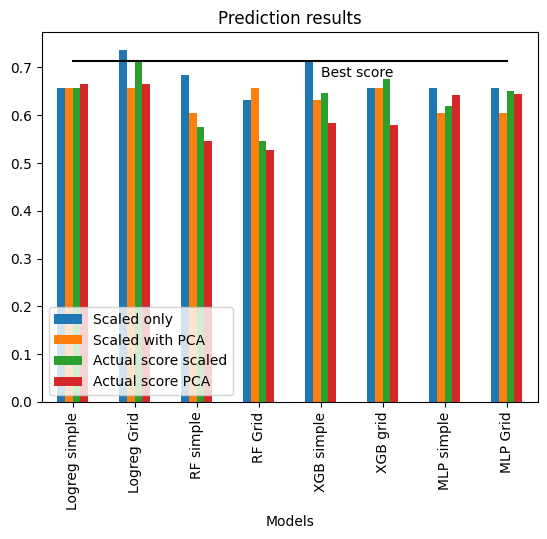

In [18]:
# Inserting results from kaggle to the results dataframe
results["Actual score scaled"].loc[0], results["Actual score PCA"].loc[0] = 0.658, 0.665
results["Actual score scaled"].loc[1], results["Actual score PCA"].loc[1] = 0.713, 0.665
results["Actual score scaled"].loc[2], results["Actual score PCA"].loc[2] = 0.575, 0.546
results["Actual score scaled"].loc[3], results["Actual score PCA"].loc[3] = 0.547, 0.528
results["Actual score scaled"].loc[4], results["Actual score PCA"].loc[4] = 0.647, 0.583
results["Actual score scaled"].loc[5], results["Actual score PCA"].loc[5] = 0.675, 0.580
results["Actual score scaled"].loc[6], results["Actual score PCA"].loc[6] = 0.619, 0.642
results["Actual score scaled"].loc[7], results["Actual score PCA"].loc[7] = 0.651, 0.645

print(results)

results.plot(x= "Models", y= ["Scaled only", "Scaled with PCA", "Actual score scaled", 
                              "Actual score PCA"], title= "Prediction results", kind= 'bar')
plt.plot(results["Models"], [0.713 for i in range(len(results["Models"]))], 'k-')
plt.xticks(rotation = 'vertical')
plt.legend(loc= 'lower left')
plt.text(x=4, y=0.68, s="Best score")
plt.show()